In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
    sys.path.append("../")

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

[2018-01-09 14:26:52,274] Making new env: MountainCar-v0


In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurized representation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [4]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = [self.featurize_state(s)]
        if a is not None:
            return self.models[a].predict(features)[0]
        else:
            ys = []
            for m in self.models:
                ys.append(m.predict(features)[0])
            return np.array(ys)
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        self.models[a].partial_fit([self.featurize_state(s)], [y])

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [12]:
def q_learning(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    nA = env.action_space.n
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, nA)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        rewardAll = 0
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        state = env.reset()
        prob = policy(state)
        action = np.random.choice(range(nA), p=prob)
        
        for t in itertools.count():
            next_state, reward, done, _ = env.step(action)
            rewardAll += reward
            if done:
                estimator.update(state, action, reward)
                break
            else:
                prob = policy(next_state)
                next_action = np.random.choice(range(nA), p=prob)
                target = reward + discount_factor*np.max(estimator.predict(next_state))
                estimator.update(state, action, target)
            state = next_state
            action = next_action
        stats.episode_lengths[i_episode] = t
        stats.episode_rewards[i_episode] = rewardAll
    
    return stats

In [13]:
estimator = Estimator()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [14]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = q_learning(env, estimator, 100, epsilon=0.0)

Episode 200/200 (-130.0)

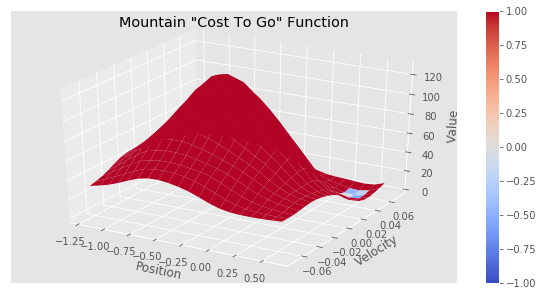

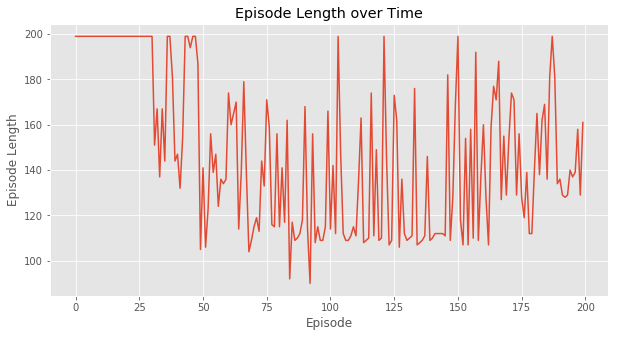

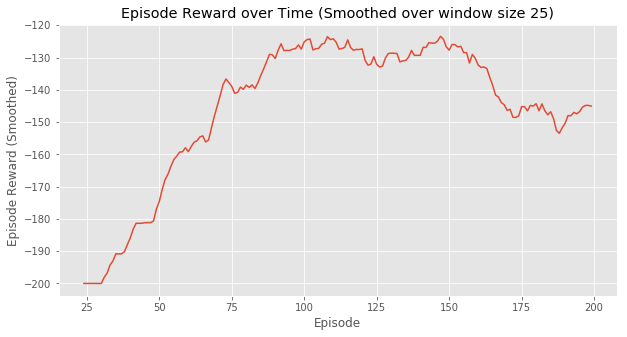

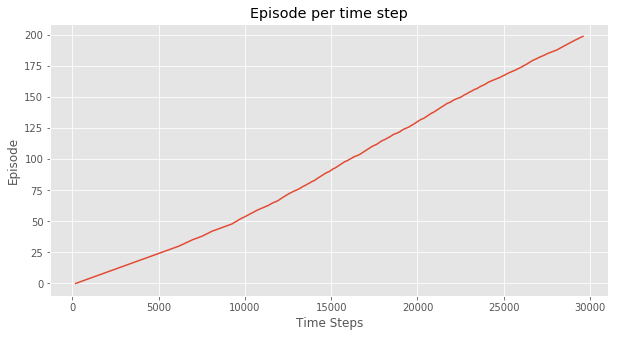

(<matplotlib.figure.Figure at 0x7f15bc6f34a8>,
 <matplotlib.figure.Figure at 0x7f15bc7f05f8>)

In [16]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)

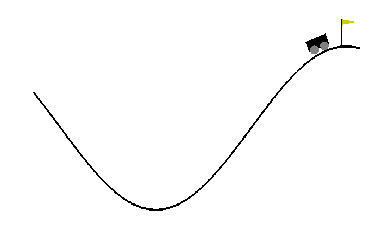

In [36]:
# Animate your policy!

import matplotlib.pyplot as plt
from IPython import display

def make_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.zeros(nA, dtype=float)
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] = 1.0
        return A
    return policy_fn

nA = env.action_space.n
state = env.reset()
policy = make_greedy_policy(estimator, nA)
plt.imshow(env.render(mode='rgb_array'))
plt.axis('off')
display.display(plt.gcf())
for t in itertools.count():
    prob = policy(state)
    action = np.random.choice(range(nA), p=prob)
    next_state, _, done, _ = env.step(action)
    if t % 5 == 0:
        display.clear_output(wait=True)
        plt.imshow(env.render(mode='rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
    if done:
        break
    state = next_state
display.clear_output(wait=True)